# EVALUATE RESULTS

### Import relevant packages

In [1]:
import pandas as pd
import os
import copy
import re
import glob
import numpy as np
import random
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import precision_recall_fscore_support, f1_score

# plotting + styles
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(font="serif", font_scale=1.2)
sns.set_style()

### Load results across test sets
Each "result" is a csv of gold labels and model predictions.
The results are stored in a nested dict: testset -> model -> train_size -> random_state ("rs1" to "rs10" for the 10 random seeds, plus "al" for active learning and "full" for models trained on all available training data)

In [73]:
results_dict = dict()
import warnings
warnings.filterwarnings('ignore')

for testset in sorted(os.listdir("./results")):
    print(testset)
    results_dict[testset] = dict()

    for model in sorted(pd.unique(["_".join(m.split("_")[:4]) for m in os.listdir(f"./results/{testset}")])):
        if "ipynb" not in model:
            print("  ", model)
            results_dict[testset][model] = dict()

            for size in sorted(pd.unique([int(i.split("_")[-2]) for i in glob.glob(f"./results/{testset}/{model}*.csv")])):
                if size!=0:
                    results_dict[testset][model][size] = dict()
                    for random_state in sorted(pd.unique([i.split("_")[-1].rstrip(".csv") for i in glob.glob(f"./results/{testset}/{model}*_{size}_*.csv")])):
                        for filename in glob.glob(f"./results/{testset}/{model}*{size}_{random_state}.csv"):
                            results_dict[testset][model][size][random_state] = pd.read_csv(filename)

            # 0-shot xlmt models
            #for filename in glob.glob(f"./results/{testset}/{model}*_20000_rs1.csv"):
            #    results_dict[testset][model][0] = dict()
            #    results_dict[testset][model][0]["rs1"] = pd.read_csv(filename)
            #    del results_dict[testset][model][20000]["rs1"] # delete redundant entry

bas19_es_test_2000
   robertuito_es_bas19_es
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
chinese_test_2000
   macbert_base_chinese_cn
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
for19_pt_test_2000
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
french_test_2000
   .DS_Store
   camembert_base_french_fr
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_cn
   macbert_base_chinese_cn
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_es
   robertuito_es_bas19_es
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_fr
   camembert_base_french_fr
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_pt
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_e

### Compute macro F1 for each model/testset combination

In [74]:
metrics_dict = copy.deepcopy(results_dict)

for testset in metrics_dict:
    print(testset)
    for model in metrics_dict[testset]:
        print(" ", model)
        for size in metrics_dict[testset][model]:
            for random_state in metrics_dict[testset][model][size]:
                metrics_dict[testset][model][size][random_state] = f1_score(metrics_dict[testset][model][size][random_state]["label"],
                                                                            metrics_dict[testset][model][size][random_state]["prediction"],
                                                                            average="macro")

bas19_es_test_2000
  robertuito_es_bas19_es
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
chinese_test_2000
  macbert_base_chinese_cn
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
for19_pt_test_2000
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
french_test_2000
  .DS_Store
  camembert_base_french_fr
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_cn
  macbert_base_chinese_cn
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_es
  robertuito_es_bas19_es
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_fr
  camembert_base_french_fr
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_pt
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ke

### Create flat df of results for easier plotting

In [75]:
%%time

metrics_df = pd.DataFrame(columns=["testset", "model", "train_size", "selection_strat", "macro_f1"])

for testset in metrics_dict:
    for model in metrics_dict[testset]:
        for size in metrics_dict[testset][model]:
            for selection_strat in metrics_dict[testset][model][size]:
                metrics_df.loc[len(metrics_df)+1] = [testset, model, int(size), selection_strat, metrics_dict[testset][model][size][selection_strat]]

metrics_df["log_train_size"] = metrics_df.train_size.apply(lambda x: np.log(x))
metrics_df["selection_strat_category"] = metrics_df.selection_strat.apply(lambda x: "active learning" if x=="al" else ("full" if x=="full" else "random"))

CPU times: user 1.43 s, sys: 121 ms, total: 1.55 s
Wall time: 1.55 s


### Validate that no results are missing
Expecting 10 results from 10 different random seeds per testset + model + train_size (n = 12) --> 120 per model

In [76]:
val_df = pd.DataFrame(metrics_df[metrics_df.selection_strat_category=="random"].groupby(["testset","model", "train_size"]).selection_strat.count()).reset_index()
val_df[val_df.selection_strat!=10]

Empty DataFrame
Columns: [testset, model, train_size, selection_strat]
Index: []

In [77]:
val_df = pd.DataFrame(metrics_df[metrics_df.selection_strat_category=="random"].groupby(["testset","model"]).selection_strat.count()).reset_index()
val_df[val_df.selection_strat!=120].sort_values("model")

Empty DataFrame
Columns: [testset, model, selection_strat]
Index: []

## Summary Plots
### DETAIL: Average macro F1 across random seeds across models for each testset + MHC

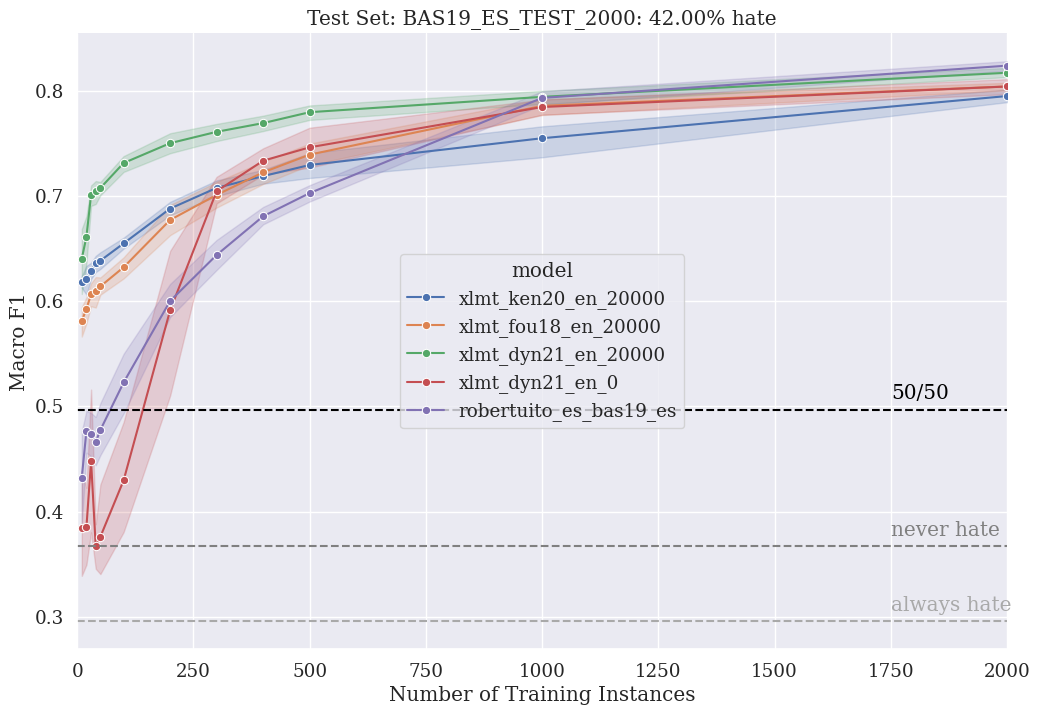

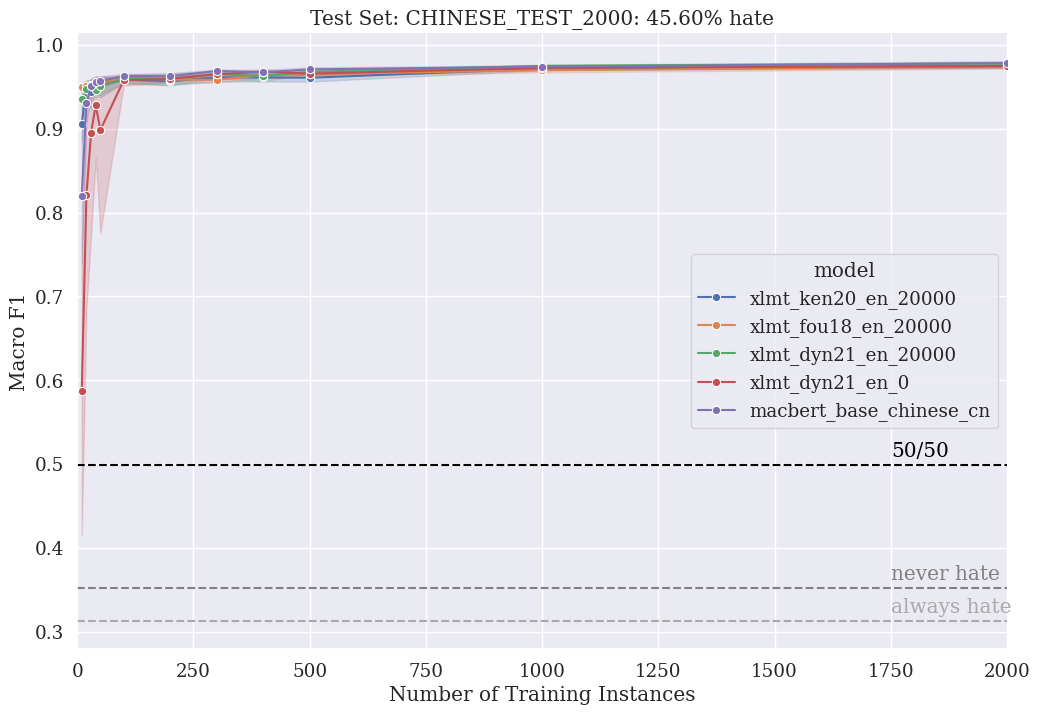

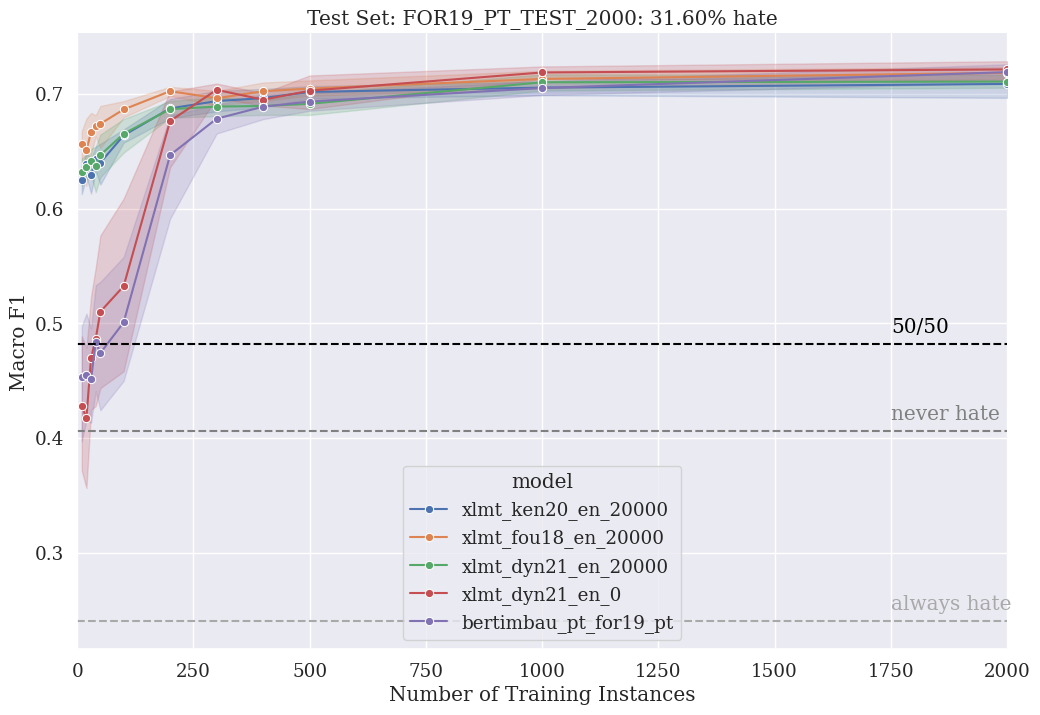

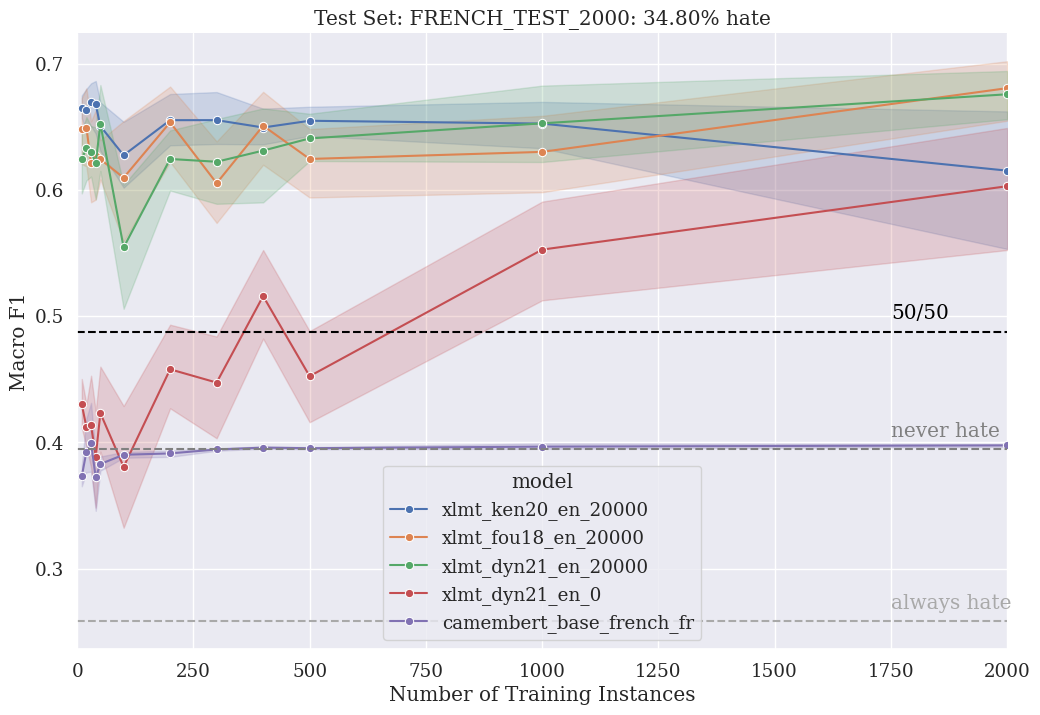

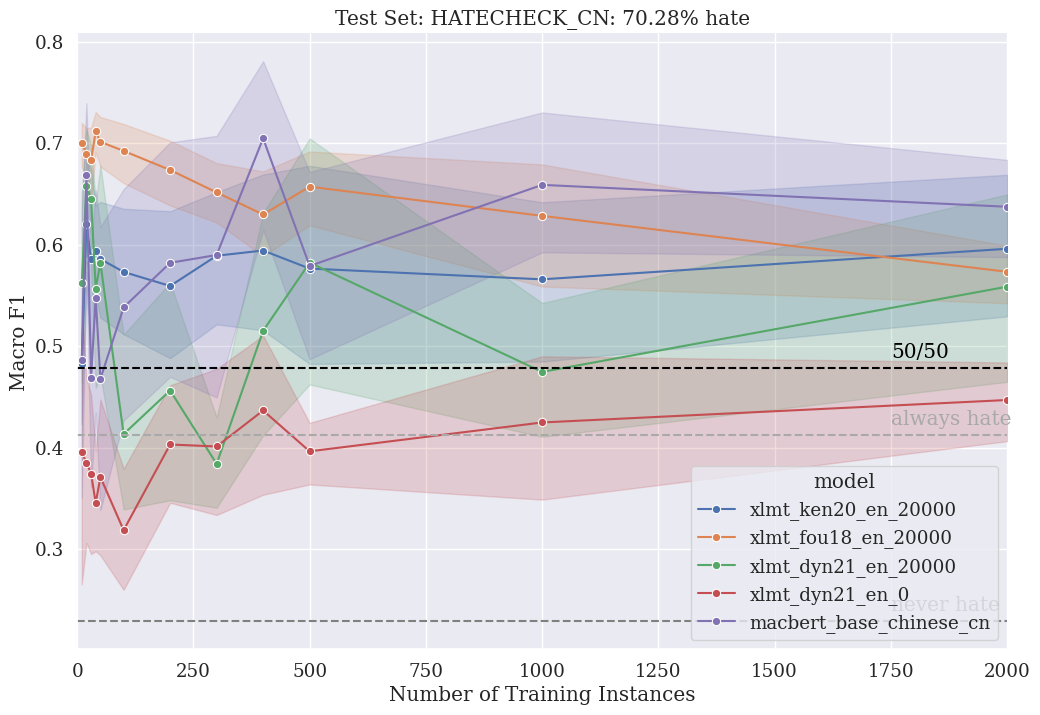

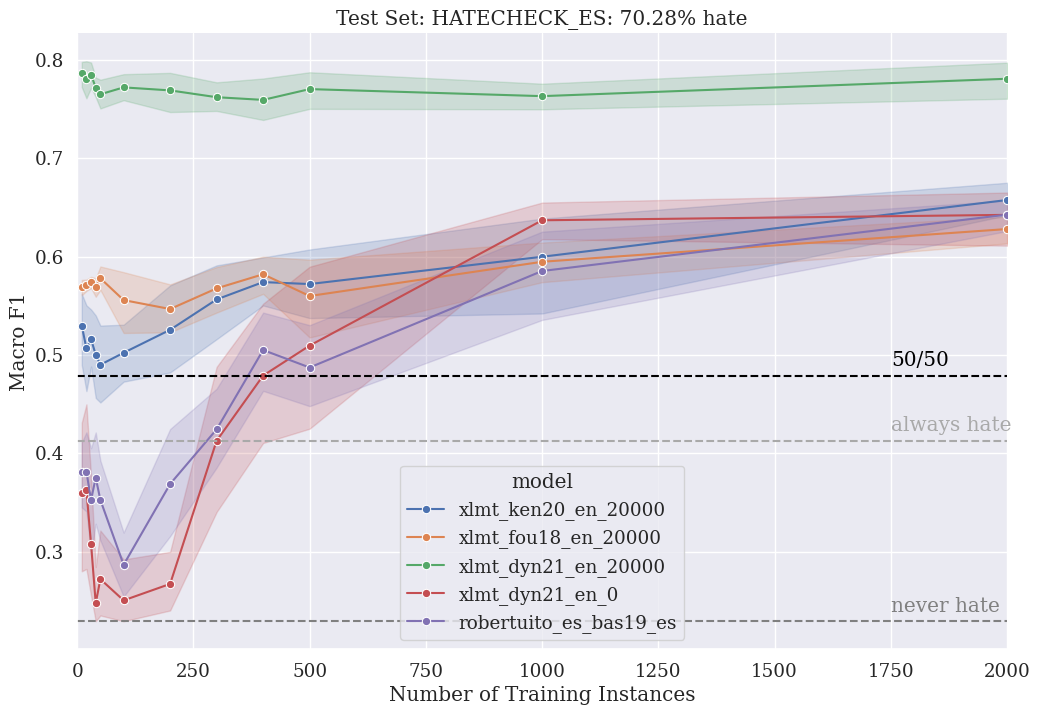

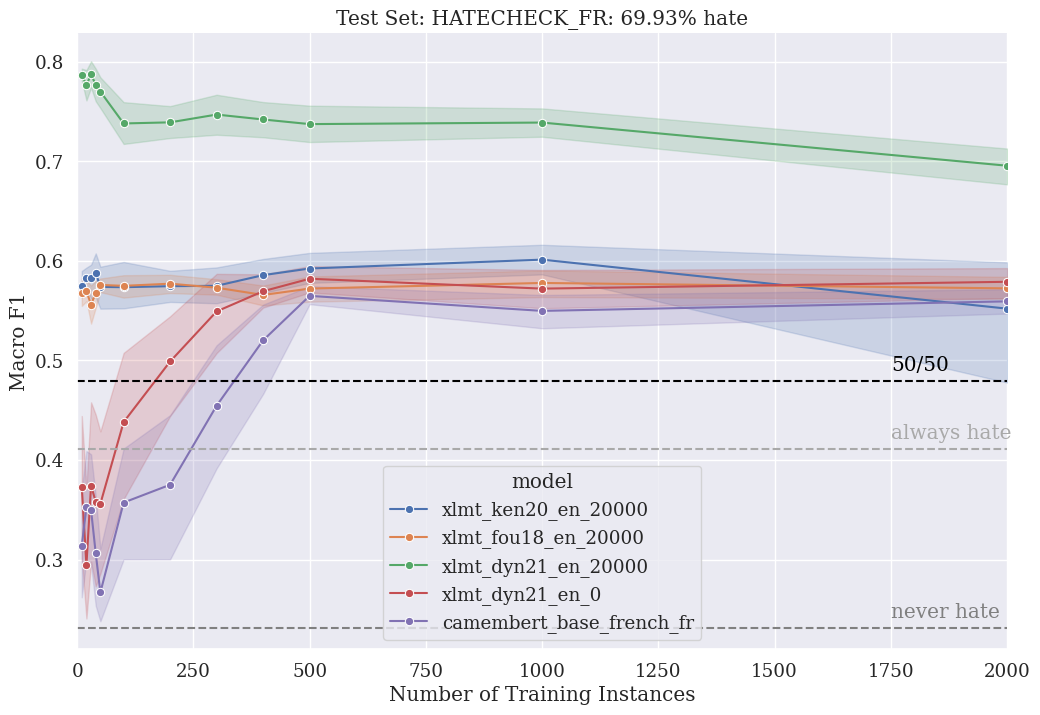

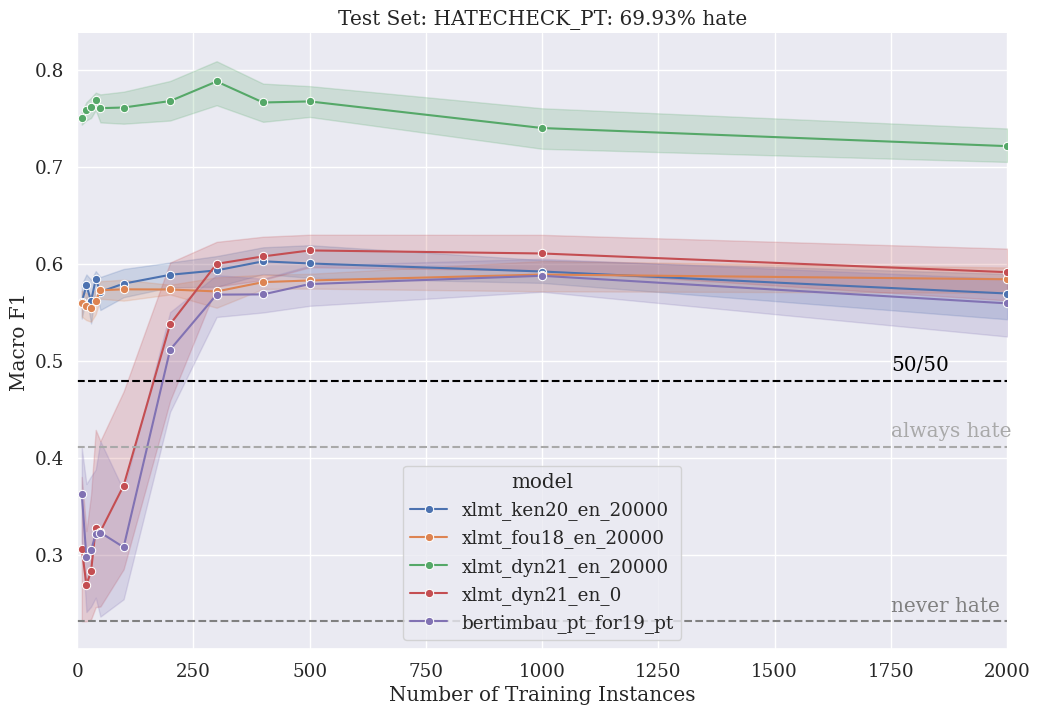

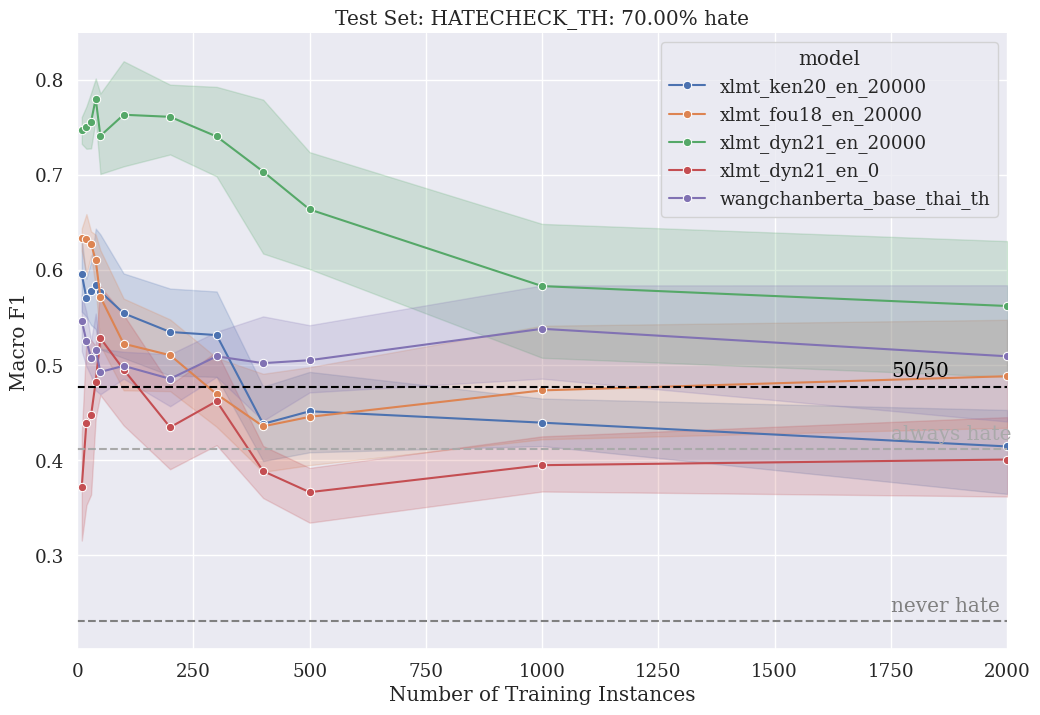

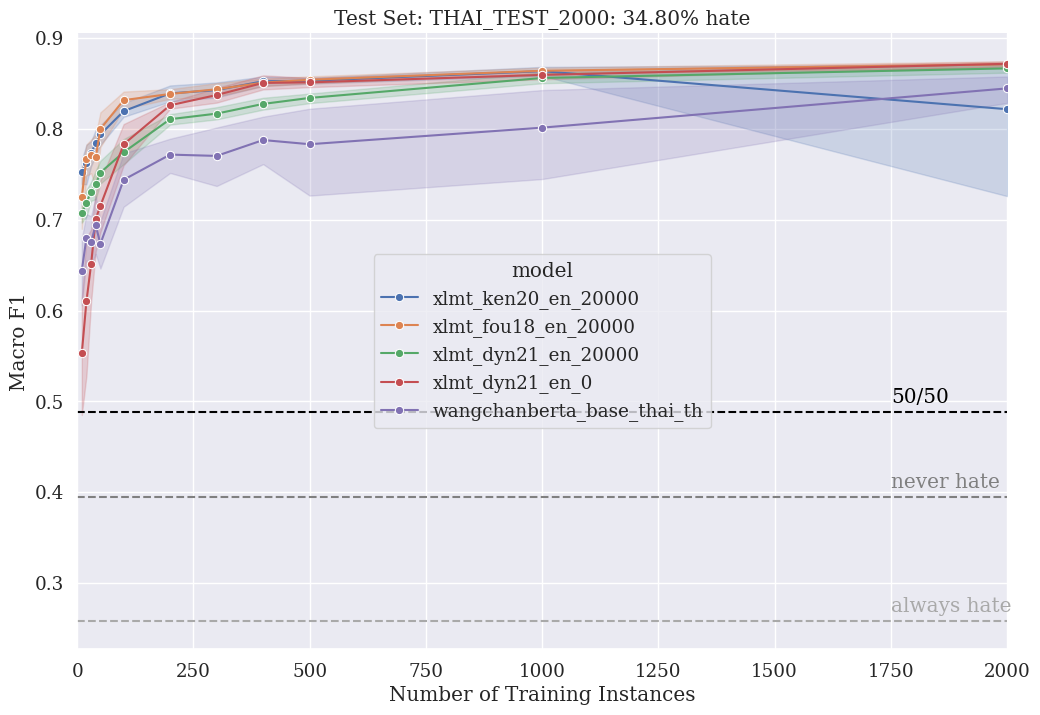

In [78]:
BASELINES = ["always hate", "never hate", "50/50"]
RESULTS_ON_FULL_DATA = True

for target_testset in sorted([t for t in metrics_dict.keys()]):

    f = plt.figure(figsize=(12,8))
    
    # Just random samples
    plot_df = metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="random")].sort_values(["model"], ascending=False)
    p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = plot_df, estimator="mean", marker="o", ci=95)
    
    # Model performance on full data: 
    if RESULTS_ON_FULL_DATA:
        for _, row in metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="full")].sort_values(["model"]).iterrows():
            p.axhline(row.macro_f1, color="blue", linestyle="--", alpha=0.3)
            p.annotate(f"{row.model}: {row.train_size}", xy= (1750,row.macro_f1),  xytext=(25,row.macro_f1+0.005), color = "blue")
    
    
    # Baseline: always hate
    if "always hate" in BASELINES:
        always_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                               len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[1],
                               average="macro")
        p.axhline(always_hate, color="darkgrey", linestyle="--")
        p.annotate('always hate', xy= (1750,always_hate),  xytext=(1750,always_hate+0.01), color = "darkgrey")
    
    
    # Baseline: never hate
    if "never hate" in BASELINES:
        never_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                              len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[0],
                              average="macro")
        p.axhline(never_hate, color="grey", linestyle="--")
        p.annotate('never hate', xy= (1750,never_hate),  xytext=(1750,never_hate+0.01), color="grey")
    
    
    # Baseline: 50/50 hate/nothate
    if "50/50" in BASELINES:
        equal_prob = list()
        for i in range(1000): # approximate estimated value by repeated sampling
            equal_prob += [f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                                    [round(random.uniform(0, 1)) for i in range(len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']))],
                                    average="macro")]
        equal_prob = sum(equal_prob)/len(equal_prob)
        p.axhline(equal_prob, color="black", linestyle="--")
        p.annotate('50/50', xy= (1750,equal_prob),  xytext=(1750,equal_prob+0.01), color="black")
    
    # Plot formatting
    p.set_title(f"Test Set: {target_testset.upper()}: {results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'].label.mean():.2%} hate")
    p.set_xlabel("Number of Training Instances")
    p.set_ylabel("Macro F1")
    p.set_xlim(0,2000)
    sns.despine()
    plt.show()

In [79]:
def f1_plot(target_testset, cell, BASELINES, FILTER, xlim=False, ylim=False, legend=True, legend_xy=False,
            xaxis_labels=True, yaxis_labels=True, yaxis_ticks=True, baseline_label=1700):
    
    # Just random samples
    plot_df = metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="random")].sort_values(["model"], ascending=False)
    
    # Filter out models that we don't want to show
    for f in FILTER:
        plot_df = plot_df[~plot_df.model.str.contains(f)]
        
    # Map full model names to shorthand:
    model_map = {"xlmt_dyn21_en_0": "X", "xlmt_dyn21_en_20000": "X+DEN", "xlmt_ken20_en_20000": "X+KEN", "xlmt_fou18_en_20000": "X+FEN",
                "robertuito_es_bas19_es": "M", "wangchanberta_base_thai_th": "M", "camembert_base_french_fr": "M", "bertimbau_pt_for19_pt": "M", "macbert_base_chinese_cn": "M"}
    plot_df["model"] = plot_df.model.apply(lambda x: model_map[x])
    
    ax = plt.subplot(cell)
    ax = sns.lineplot(ax=ax, x="train_size", y="macro_f1", hue="model", hue_order=sorted(pd.unique(plot_df.model)),
                      data = plot_df, estimator="mean", marker="o", ci=95)
    sns.despine()
    
    # Plot formatting
    if legend_xy!=False:
        ax.legend(title="Model", loc=legend_xy, framealpha=1)
    else:
        ax.legend(title="Model", framealpha=1)

    lss = [':', ':', '-', '-', "-"]
    handles, labels = ax.get_legend_handles_labels()
    for line, ls, handle in zip(ax.lines, lss, handles):
        line.set_linestyle(ls)
        handle.set_linestyle(ls)
    
    ax.set_title(target_testset.replace("_test_2000", "").replace("_test_1000", "").upper())
    ax.set_xlabel("N")
    ax.set_ylabel("Macro F1")
    
    if xlim:
        ax.set_xlim(xlim)
    
    if ylim:
        ax.set_ylim(ylim)
    
    if not legend:
        ax.get_legend().remove()
        
    if not xaxis_labels:
        ax.set_xlabel("")
        ax.xaxis.set_ticklabels([])
    
    if not yaxis_labels:
        ax.set_ylabel("")
        
    if not yaxis_ticks:
        ax.yaxis.set_ticklabels([])
    
    # Baseline: always hate
    if "always hate" in BASELINES:
        always_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                               len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[1],
                               average="macro")
        ax.axhline(always_hate, color="darkgrey", linestyle="--")
        ax.annotate('always hate', xy= (baseline_label,always_hate),  xytext=(baseline_label,always_hate+0.01),
                    color = "darkgrey", horizontalalignment="right")
    
    
    # Baseline: never hate
    if "never hate" in BASELINES:
        never_hate = f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                              len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1'])*[0],
                              average="macro")
        ax.axhline(never_hate, color="grey", linestyle="--")
        ax.annotate('never hate', xy= (baseline_label,never_hate),  xytext=(baseline_label,never_hate+0.01),
                    color="grey", horizontalalignment="right")
    
    
    # Baseline: 50/50 hate/nothate
    if "50/50" in BASELINES:
        equal_prob = list()
        for i in range(1000): # approximate estimated value by repeated sampling
            equal_prob += [f1_score(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']["label"],
                                    [round(random.uniform(0, 1)) for i in range(len(results_dict[target_testset]['xlmt_dyn21_en_20000'][10]['rs1']))],
                                    average="macro")]
        equal_prob = sum(equal_prob)/len(equal_prob)
        ax.axhline(equal_prob, color="black", linestyle="--")
        ax.annotate('50/50', xy= (baseline_label,equal_prob),  xytext=(baseline_label,equal_prob+0.01),
                    color="black", horizontalalignment="right")


### FIGURE 1: Macro F1 on Held-Out Test Sets

In [109]:
metrics_df[(metrics_df.testset=="hatecheck_th")&(metrics_df.model=="wangchanberta_base_thai_th")&(metrics_df.train_size==200)].macro_f1.mean()

0.485913995272471

In [110]:
metrics_df[(metrics_df.testset=="hatecheck_th")&(metrics_df.model=="xlmt_fou18_en_20000")&(metrics_df.train_size==20)].macro_f1.mean()

0.6330387844606259

In [82]:
metrics_dict

{'bas19_es_test_2000': {'robertuito_es_bas19_es': {10: {'rs1': 0.47265625,
    'rs10': 0.3747252747252747,
    'rs2': 0.3226385221800727,
    'rs3': 0.44829665360265303,
    'rs4': 0.416120332246043,
    'rs5': 0.5143556223761536,
    'rs6': 0.464681659803611,
    'rs7': 0.49957136652977385,
    'rs8': 0.503063768107177,
    'rs9': 0.3058883008553906},
   20: {'rs1': 0.48331258676086264,
    'rs10': 0.43719289131328876,
    'rs2': 0.47337652248278117,
    'rs3': 0.42314902944824206,
    'rs4': 0.4386672325976231,
    'rs5': 0.4916360030272189,
    'rs6': 0.48219120977518315,
    'rs7': 0.5320221634303399,
    'rs8': 0.5024950475187442,
    'rs9': 0.5007236971993134},
   30: {'rs1': 0.5282754653283981,
    'rs10': 0.45130795413960745,
    'rs2': 0.45384541109448173,
    'rs3': 0.45551179759956356,
    'rs4': 0.43210172160058313,
    'rs5': 0.4213166535623094,
    'rs6': 0.5041736263951433,
    'rs7': 0.49874065737399187,
    'rs8': 0.4933265910257786,
    'rs9': 0.5000766689142211},
   

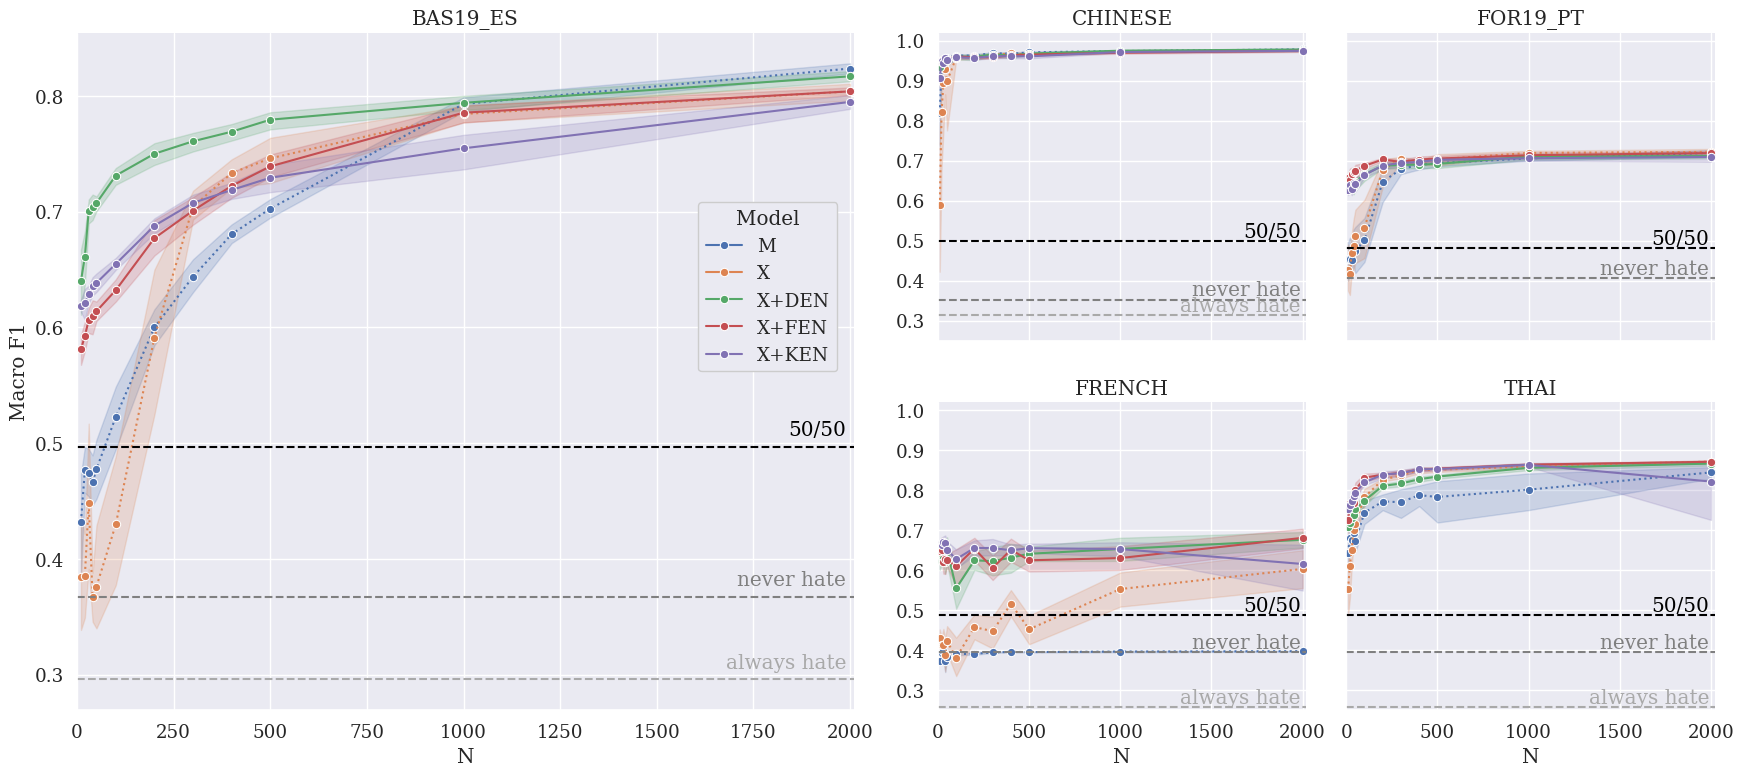

In [84]:
BASELINES = ["always hate", "never hate", "50/50"]
FILTER = []#["ken", "_0"]

# set up plot layout
fig = plt.figure(figsize=(16, 8)) 
gs_full = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
gs_l =  gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_full[0])
gs_r =  gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_full[1])

# iterate through cells in plot grid


# left side
for target_testset, cell in zip([t for t in metrics_dict.keys() if not "hatecheck" in t][0:1], [c for c in gs_l]):
    f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2010), legend=True, legend_xy=(0.8,0.5),
            yaxis_labels=True, baseline_label=1990)

# right side
for target_testset, cell in zip(sorted([t for t in metrics_dict.keys() if not "hatecheck" in t][1:]), [c for c in gs_r]):
    if cell==gs_r[0]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.25,1.02), legend=False, xaxis_labels=False, yaxis_labels=False, baseline_label=1990)
    if cell==gs_r[1]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.25,1.02), legend=False, xaxis_labels=False, yaxis_labels=False, yaxis_ticks=False, baseline_label=1990)
    if cell==gs_r[2]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.25,1.02), legend=False, xaxis_labels=True, yaxis_labels=False, baseline_label=1990)
    if cell==gs_r[3]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.25,1.02), legend=False, xaxis_labels=True, yaxis_labels=False, yaxis_ticks=False, baseline_label=1990)

fig.tight_layout()
fig.tight_layout(rect=[-0.055,0,1.05, 1])

plt.savefig('macroF1_testsets_2000.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

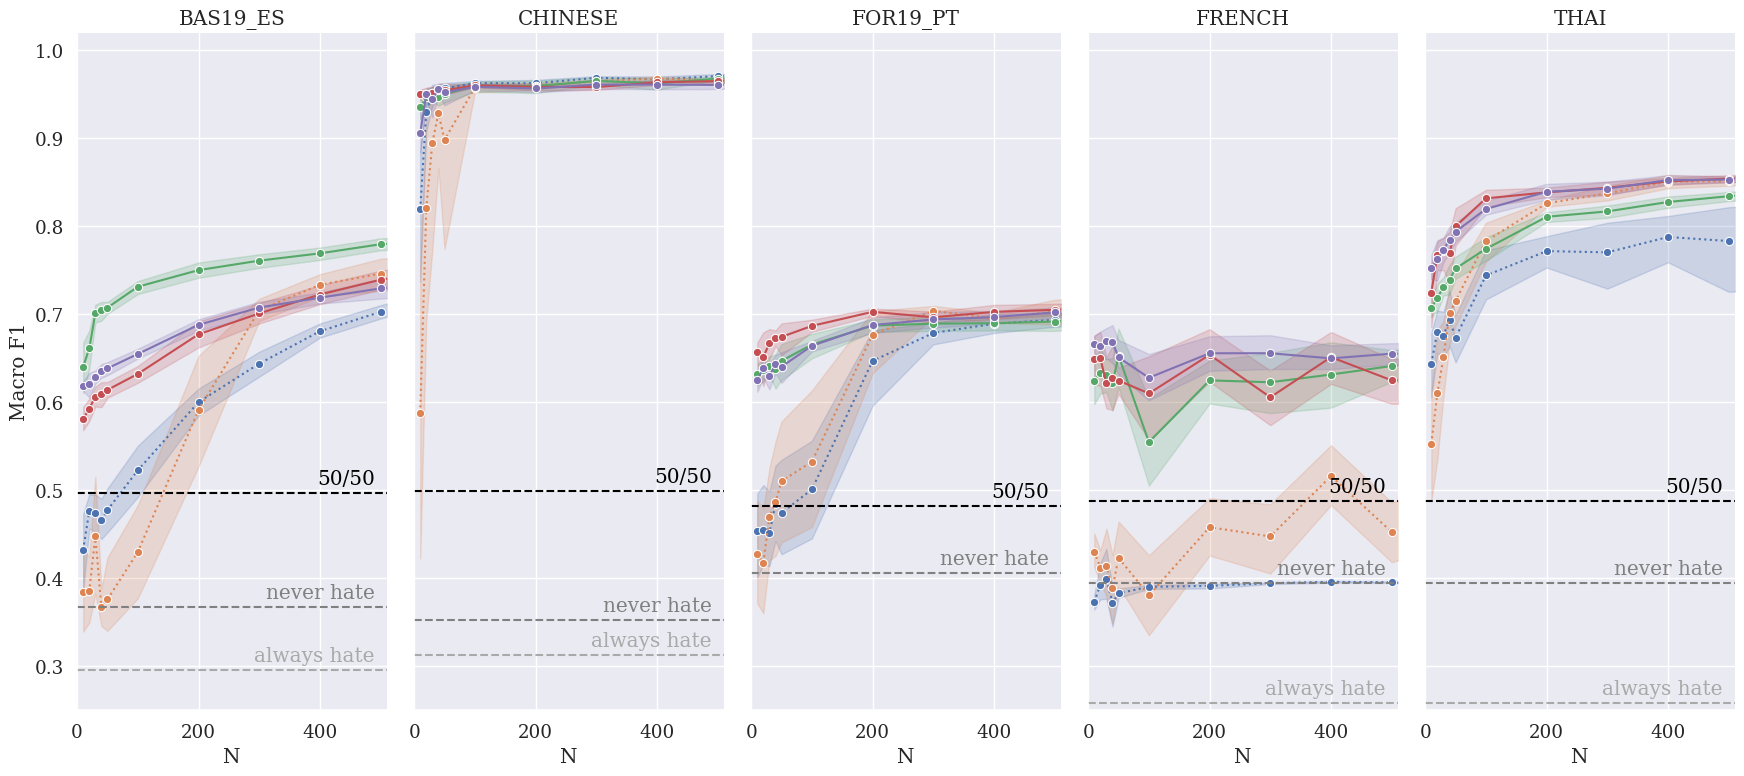

In [85]:
BASELINES = ["always hate", "never hate", "50/50"]
FILTER = []#["fou", "ken", "_0"]

# set up plot layout
fig = plt.figure(figsize=(16, 8))
gs_full = gridspec.GridSpec(1, 5)

# iterate through cells in plot grid
for target_testset, cell in zip(sorted([t for t in metrics_dict.keys() if not "hatecheck" in t]), [c for c in gs_full]):
    if cell!=gs_full[0]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,510), ylim=(0.25,1.02), legend=False, yaxis_labels=False, yaxis_ticks=False, baseline_label=490)
    else:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,510), ylim=(0.25,1.02), legend=False, yaxis_labels=True, baseline_label=490)

fig.tight_layout()
fig.tight_layout(rect=[-0.055,0,1.05, 1])

plt.savefig('macroF1_testsets_500.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

### TABLE 1: Macro F1 on Held-Out Test Sets

In [86]:
def generate_latex_table(MODELS, TESTSETS, TRAIN_SIZES):

    # Map full model names to shorthand:
    model_map = {"xlmt_dyn21_en_0": "X", "xlmt_dyn21_en_20000": "X+DEN", "xlmt_ken20_en_20000": "X+KEN", "xlmt_fou18_en_20000": "X+FEN",
                "robertuito_es_bas19_es": "M", "wangchanberta_base_thai_th": "M", "camembert_base_french_fr": "M", "bertimbau_pt_for19_pt": "M", "macbert_base_chinese_cn": "M"}
    metrics_df["model_shorthand"] = metrics_df.model.apply(lambda x: model_map[x])

    
    for model in MODELS:
        row = model
        for target_testset in TESTSETS:
            for size in TRAIN_SIZES:
                row += " & {:.2f}".format(metrics_df[(metrics_df.testset==target_testset)&(metrics_df.train_size==size)&(metrics_df.model_shorthand==model)].macro_f1.mean())
        row += ' \\' + "\\"
        print(row)
    

In [87]:
MODELS = ["M", "X", "X+DEN", "X+FEN", "X+KEN"]
TESTSETS = [t for t in metrics_dict.keys() if "hatecheck" not in t]
TRAIN_SIZES = [20,200,2000]

generate_latex_table(MODELS, TESTSETS, TRAIN_SIZES)

M & 0.48 & 0.60 & 0.82 & 0.93 & 0.96 & 0.98 & 0.45 & 0.65 & 0.72 & 0.39 & 0.39 & 0.40 & 0.68 & 0.77 & 0.84 \\
X & 0.39 & 0.59 & 0.80 & 0.82 & 0.96 & 0.97 & 0.42 & 0.68 & 0.72 & 0.41 & 0.46 & 0.60 & 0.61 & 0.83 & 0.87 \\
X+DEN & 0.66 & 0.75 & 0.82 & 0.95 & 0.96 & 0.98 & 0.64 & 0.69 & 0.71 & 0.63 & 0.62 & 0.68 & 0.72 & 0.81 & 0.87 \\
X+FEN & 0.59 & 0.68 & 0.80 & 0.95 & 0.96 & 0.97 & 0.65 & 0.70 & 0.72 & 0.65 & 0.65 & 0.68 & 0.77 & 0.84 & 0.87 \\
X+KEN & 0.62 & 0.69 & 0.79 & 0.95 & 0.96 & 0.97 & 0.64 & 0.69 & 0.71 & 0.66 & 0.66 & 0.62 & 0.76 & 0.84 & 0.82 \\


### APPENDIX: Macro F1 on Held-Out Test Sets

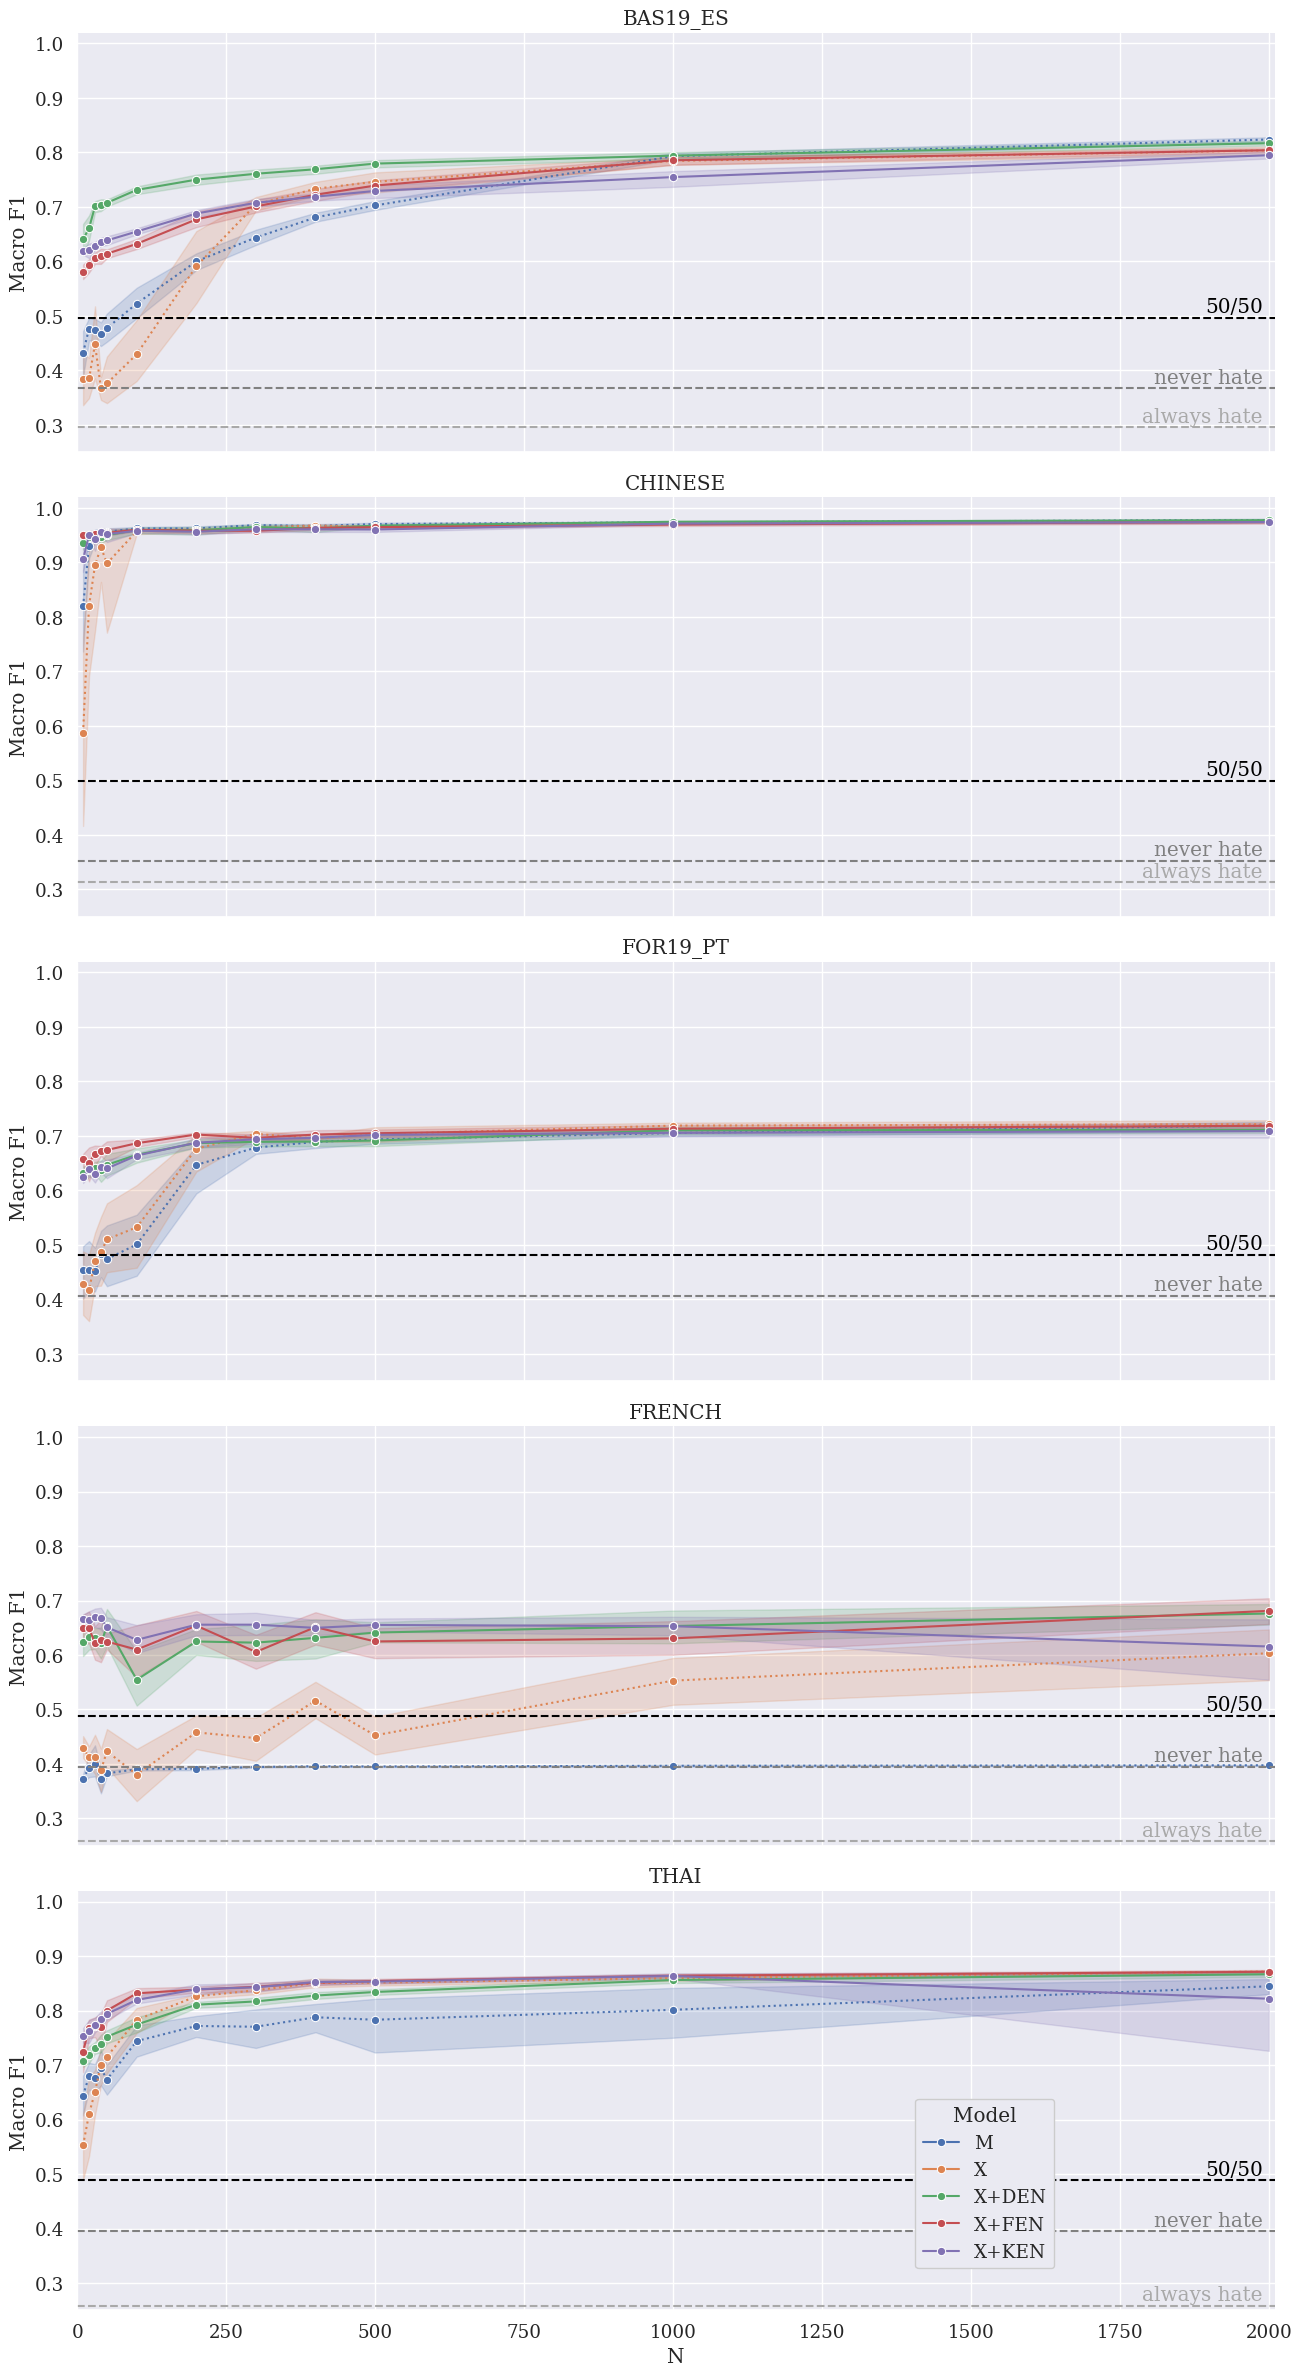

In [88]:
BASELINES = ["always hate", "never hate", "50/50"]
FILTER = []#["fou", "ken", "_0"]

# set up plot layout
fig = plt.figure(figsize=(12, 24))
gs_full = gridspec.GridSpec(5, 1)

# iterate through cells in plot grid
for target_testset, cell in zip(sorted([t for t in metrics_dict.keys() if not "hatecheck" in t]), [c for c in gs_full]):
    if cell!=gs_full[-1]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2010),  ylim=(0.25,1.02), legend=False, xaxis_labels=False,
            yaxis_labels=True, baseline_label=1990)
    else:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2010),  ylim=(0.25,1.02), legend=True, legend_xy=(0.7,0.1),
            yaxis_labels=True, baseline_label=1990)

fig.tight_layout()
fig.tight_layout(rect=[-0.055,0,1.05, 1])

plt.savefig('macroF1_testsets_fullpage.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

In [89]:
MODELS = ["M", "X", "X+DEN", "X+FEN", "X+KEN"]
TESTSETS = [t for t in metrics_dict.keys() if "hatecheck" not in t]
TRAIN_SIZES = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000]

for testset in TESTSETS:
    print(testset)
    generate_latex_table(MODELS, [testset], TRAIN_SIZES)
    print()

bas19_es_test_2000
M & 0.43 & 0.48 & 0.47 & 0.47 & 0.48 & 0.52 & 0.60 & 0.64 & 0.68 & 0.70 & 0.79 & 0.82 \\
X & 0.38 & 0.39 & 0.45 & 0.37 & 0.38 & 0.43 & 0.59 & 0.70 & 0.73 & 0.75 & 0.78 & 0.80 \\
X+DEN & 0.64 & 0.66 & 0.70 & 0.70 & 0.71 & 0.73 & 0.75 & 0.76 & 0.77 & 0.78 & 0.79 & 0.82 \\
X+FEN & 0.58 & 0.59 & 0.61 & 0.61 & 0.61 & 0.63 & 0.68 & 0.70 & 0.72 & 0.74 & 0.79 & 0.80 \\
X+KEN & 0.62 & 0.62 & 0.63 & 0.64 & 0.64 & 0.65 & 0.69 & 0.71 & 0.72 & 0.73 & 0.75 & 0.79 \\

chinese_test_2000
M & 0.82 & 0.93 & 0.95 & 0.96 & 0.96 & 0.96 & 0.96 & 0.97 & 0.97 & 0.97 & 0.97 & 0.98 \\
X & 0.59 & 0.82 & 0.89 & 0.93 & 0.90 & 0.96 & 0.96 & 0.96 & 0.97 & 0.97 & 0.97 & 0.97 \\
X+DEN & 0.93 & 0.95 & 0.95 & 0.95 & 0.95 & 0.96 & 0.96 & 0.97 & 0.96 & 0.97 & 0.97 & 0.98 \\
X+FEN & 0.95 & 0.95 & 0.95 & 0.95 & 0.95 & 0.96 & 0.96 & 0.96 & 0.96 & 0.96 & 0.97 & 0.97 \\
X+KEN & 0.91 & 0.95 & 0.94 & 0.96 & 0.95 & 0.96 & 0.96 & 0.96 & 0.96 & 0.96 & 0.97 & 0.97 \\

for19_pt_test_2000
M & 0.45 & 0.45 & 0.45 & 0.4

### FIGURE 2: Macro F1 on HateCheck

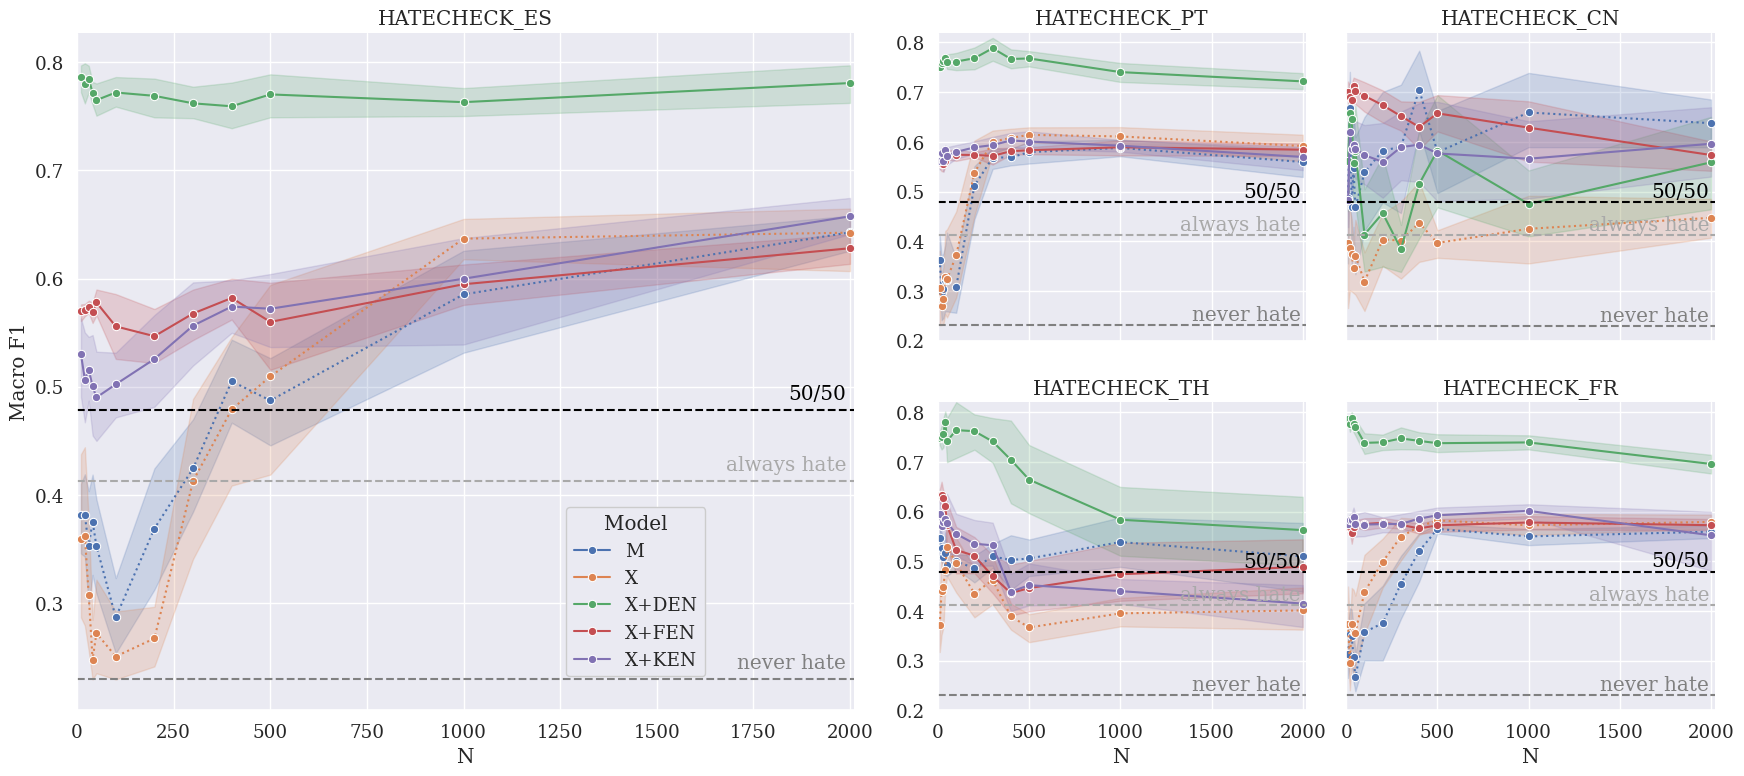

In [90]:
BASELINES = ["always hate", "never hate", "50/50"]
FILTER = []#["ken", "_0"]
RESULTS_ON_FULL_DATA = True

# set up plot layout
fig = plt.figure(figsize=(16, 8)) 
gs_full = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
gs_l =  gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs_full[0])
gs_r =  gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_full[1])

# iterate through cells in plot grid

# left side

for target_testset, cell in zip(["hatecheck_es"], [c for c in gs_l]):
    f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2010), legend=True, legend_xy=(0.63,0.05), yaxis_labels=True, baseline_label=1990)

# right side
for target_testset, cell in zip(["hatecheck_pt", "hatecheck_cn", "hatecheck_th", "hatecheck_fr"], [c for c in gs_r]):
    if cell==gs_r[0]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.2,0.82), legend=False, xaxis_labels=False, yaxis_labels=False, baseline_label=1990)
    if cell==gs_r[1]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.2,0.82), legend=False, xaxis_labels=False, yaxis_labels=False, yaxis_ticks=False, baseline_label=1990)
    if cell==gs_r[2]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.2,0.82), legend=False, xaxis_labels=True, yaxis_labels=False, baseline_label=1990)
    if cell==gs_r[3]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2020), ylim=(0.2,0.82), legend=False, xaxis_labels=True, yaxis_labels=False, yaxis_ticks=False, baseline_label=1990)

fig.tight_layout()
fig.tight_layout(rect=[-0.055,0,1.05, 1])

plt.savefig('macroF1_hatecheck_2000.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

### TABLE 2: Macro F1 on HateCheck

In [91]:
MODELS = ["M", "X", "X+DEN", "X+FEN", "X+KEN"]
TESTSETS = ["hatecheck_es", "hatecheck_pt", "hatecheck_hi", "hatecheck_ar", "hatecheck_it"]
TRAIN_SIZES = [20,200,2000]

generate_latex_table(MODELS, TESTSETS, TRAIN_SIZES)

M & 0.38 & 0.37 & 0.64 & 0.30 & 0.51 & 0.56 & nan & nan & nan & nan & nan & nan & nan & nan & nan \\
X & 0.36 & 0.27 & 0.64 & 0.27 & 0.54 & 0.59 & nan & nan & nan & nan & nan & nan & nan & nan & nan \\
X+DEN & 0.78 & 0.77 & 0.78 & 0.76 & 0.77 & 0.72 & nan & nan & nan & nan & nan & nan & nan & nan & nan \\
X+FEN & 0.57 & 0.55 & 0.63 & 0.56 & 0.57 & 0.58 & nan & nan & nan & nan & nan & nan & nan & nan & nan \\
X+KEN & 0.51 & 0.53 & 0.66 & 0.58 & 0.59 & 0.57 & nan & nan & nan & nan & nan & nan & nan & nan & nan \\


### APPENDIX: Macro F1 on HateCheck

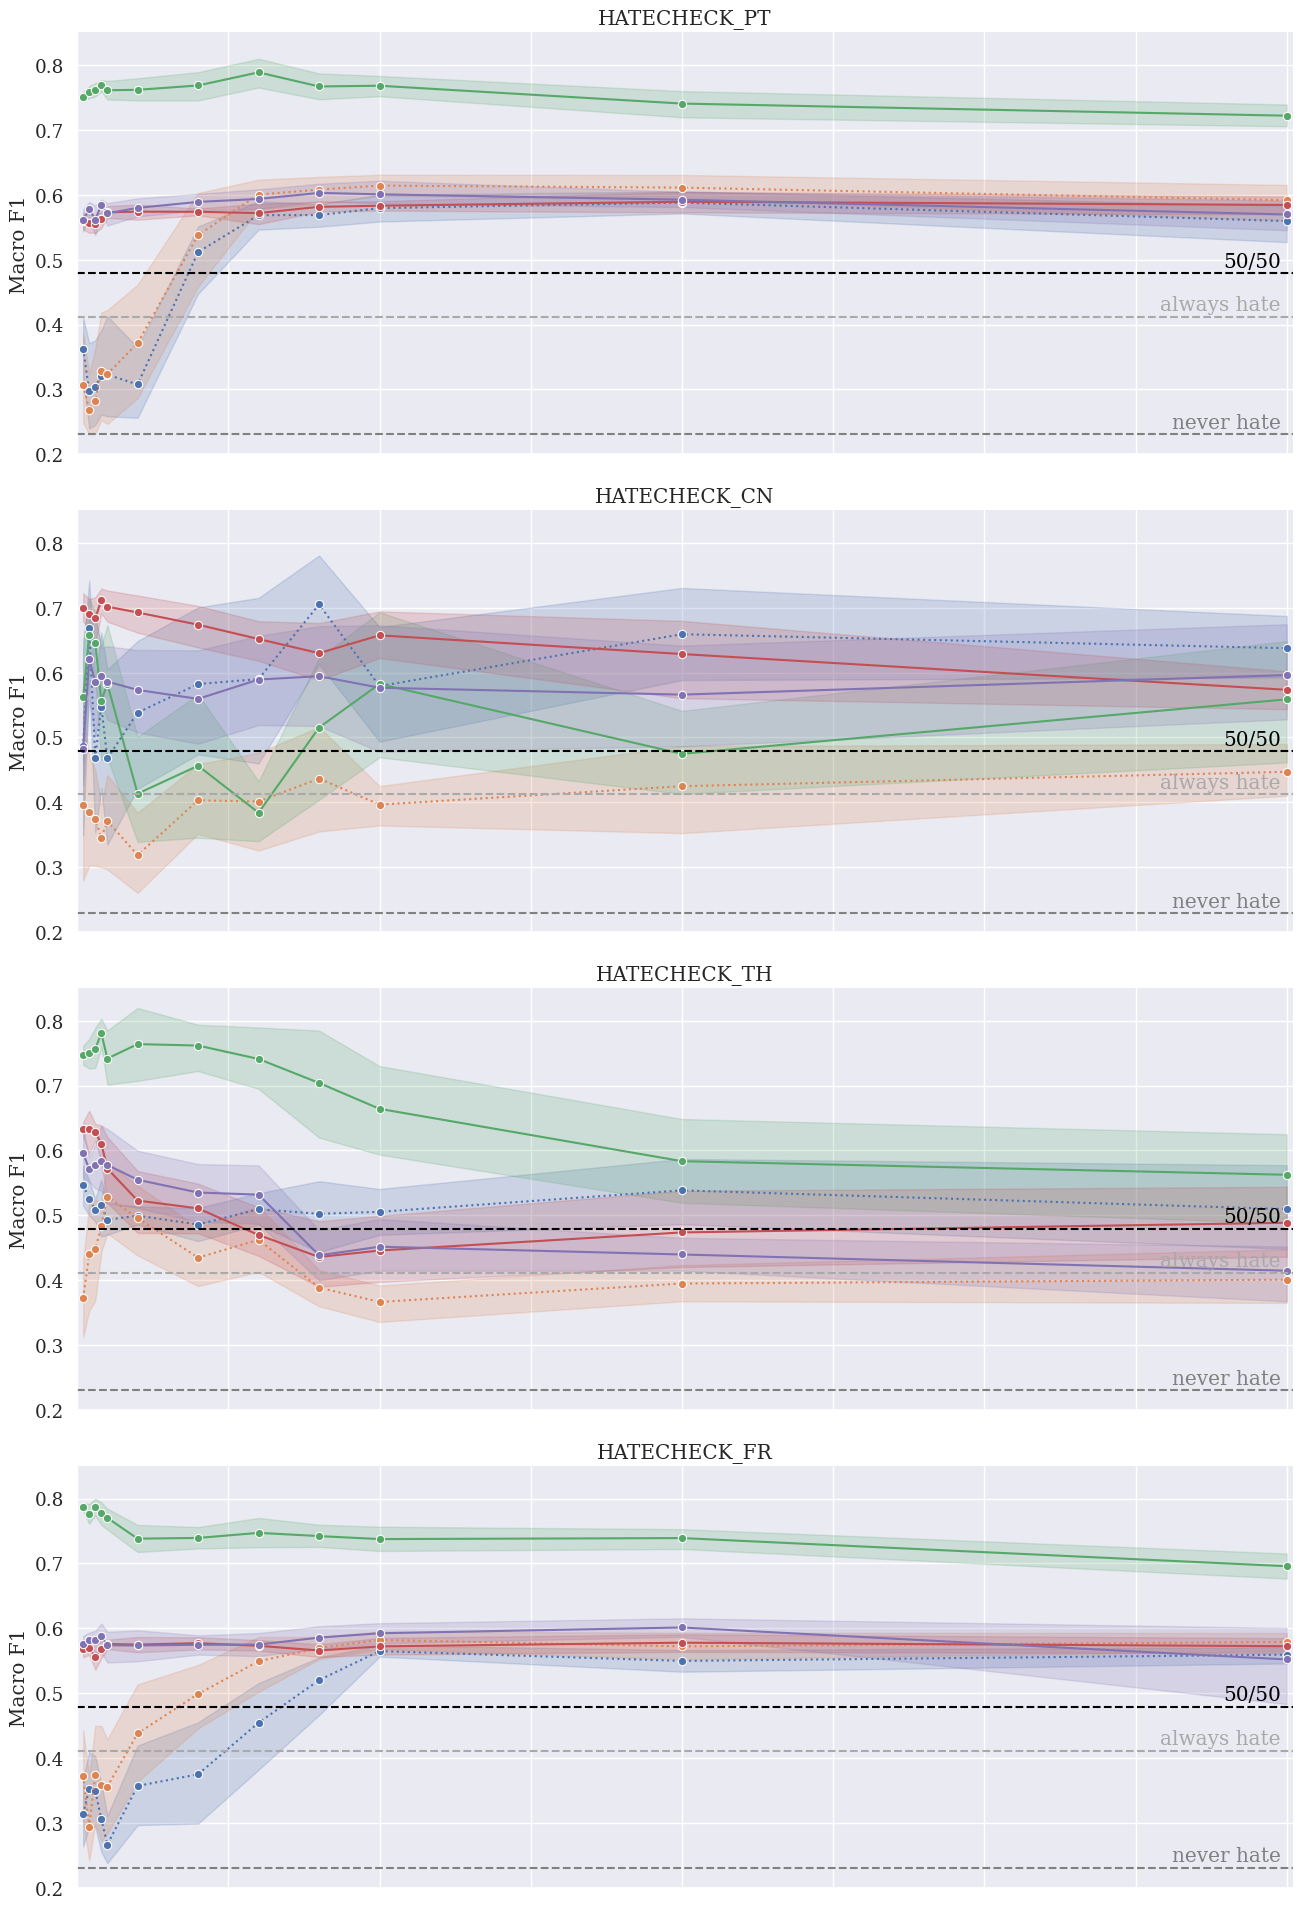

In [92]:
BASELINES = ["always hate", "never hate", "50/50"]
FILTER = []#["fou", "ken", "_0"]

# set up plot layout
fig = plt.figure(figsize=(12, 24))
gs_full = gridspec.GridSpec(5, 1)

# iterate through cells in plot grid
for target_testset, cell in zip(["hatecheck_pt", "hatecheck_cn", "hatecheck_th", "hatecheck_fr"], [c for c in gs_full]):
    if cell!=gs_full[-1]:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2010),  ylim=(0.2,0.85), legend=False, xaxis_labels=False,
            yaxis_labels=True, baseline_label=1990)
    else:
        f1_plot(target_testset, cell, BASELINES, FILTER, xlim=(0,2010),  ylim=(0.2,0.85), legend=True, legend_xy=(0.65,0.03),
            yaxis_labels=True, baseline_label=1990)

fig.tight_layout()
fig.tight_layout(rect=[-0.055,0,1.05, 1])

plt.savefig('macroF1_hatecheck_fullpage.png', bbox_inches="tight", pad_inches=0.1)
plt.show()

In [93]:
MODELS = ["M", "X", "X+DEN", "X+FEN", "X+KEN"]
TESTSETS = ["hatecheck_es", "hatecheck_pt", "hatecheck_cn", "hatecheck_th", "hatecheck_fr"]
TRAIN_SIZES = [10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000]

for testset in TESTSETS:
    print(testset)
    generate_latex_table(MODELS, [testset], TRAIN_SIZES)
    print()

hatecheck_es
M & 0.38 & 0.38 & 0.35 & 0.38 & 0.35 & 0.29 & 0.37 & 0.42 & 0.50 & 0.49 & 0.59 & 0.64 \\
X & 0.36 & 0.36 & 0.31 & 0.25 & 0.27 & 0.25 & 0.27 & 0.41 & 0.48 & 0.51 & 0.64 & 0.64 \\
X+DEN & 0.79 & 0.78 & 0.78 & 0.77 & 0.77 & 0.77 & 0.77 & 0.76 & 0.76 & 0.77 & 0.76 & 0.78 \\
X+FEN & 0.57 & 0.57 & 0.57 & 0.57 & 0.58 & 0.56 & 0.55 & 0.57 & 0.58 & 0.56 & 0.59 & 0.63 \\
X+KEN & 0.53 & 0.51 & 0.52 & 0.50 & 0.49 & 0.50 & 0.53 & 0.56 & 0.57 & 0.57 & 0.60 & 0.66 \\

hatecheck_pt
M & 0.36 & 0.30 & 0.30 & 0.32 & 0.32 & 0.31 & 0.51 & 0.57 & 0.57 & 0.58 & 0.59 & 0.56 \\
X & 0.31 & 0.27 & 0.28 & 0.33 & 0.32 & 0.37 & 0.54 & 0.60 & 0.61 & 0.61 & 0.61 & 0.59 \\
X+DEN & 0.75 & 0.76 & 0.76 & 0.77 & 0.76 & 0.76 & 0.77 & 0.79 & 0.77 & 0.77 & 0.74 & 0.72 \\
X+FEN & 0.56 & 0.56 & 0.55 & 0.56 & 0.57 & 0.57 & 0.57 & 0.57 & 0.58 & 0.58 & 0.59 & 0.58 \\
X+KEN & 0.56 & 0.58 & 0.56 & 0.58 & 0.57 & 0.58 & 0.59 & 0.59 & 0.60 & 0.60 & 0.59 & 0.57 \\

hatecheck_cn
M & 0.49 & 0.67 & 0.47 & 0.55 & 0.47 & 0.54 &

## HateCheck Deep Dive

In [94]:
# load hatecheck cases

# DATA=/Users/moolansky/Macquarie/session_3/COMP8240/project/test-with-cursor/efficient-low-resource-hate-detection_copy


hatecheck_dict = dict()

# for hc in sorted(os.listdir("../0_data/hatecheck/")):
for hc in sorted(os.listdir("/Users/moolansky/Macquarie/session_3/COMP8240/project/test-with-cursor/efficient-low-resource-hate-detection_copy/0_data/hatecheck/")):
    print(hc)
    if "ipynb" not in hc:
        # hatecheck_dict[f"hatecheck_{hc.split('_')[-1].split('.')[0]}"] = pd.read_csv(f"../0_data/hatecheck/{hc}")[["mhc_case_id", "functionality", "text", "label", "target_ident"]]
        hatecheck_dict[f"hatecheck_{hc.split('_')[-1].split('.')[0]}"] = pd.read_csv(f"/Users/moolansky/Macquarie/session_3/COMP8240/project/test-with-cursor/efficient-low-resource-hate-detection_copy/0_data/hatecheck/{hc}")[["mhc_case_id", "functionality", "text", "label", "target_ident"]]


hatecheck_cases_final_ar.csv
hatecheck_cases_final_cn.csv
hatecheck_cases_final_de.csv
hatecheck_cases_final_es.csv
hatecheck_cases_final_fr.csv
hatecheck_cases_final_hi.csv
hatecheck_cases_final_it.csv
hatecheck_cases_final_nl.csv
hatecheck_cases_final_pl.csv
hatecheck_cases_final_pt.csv
hatecheck_cases_final_th.csv
hatecheck_cases_final_zh.csv


In [95]:
# attach hatecheck case info to results on hatecheck cases
for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                results_dict[testset][model][size][random_state] = hatecheck_dict[testset].merge(results_dict[testset][model][size][random_state][["index", "prediction"]], left_index=True, right_on="index")
                results_dict[testset][model][size][random_state].drop(columns=["index"], inplace=True)

hatecheck_cn
hatecheck_es
hatecheck_fr
hatecheck_pt
hatecheck_th


In [96]:
mhc_metrics_dict = copy.deepcopy(results_dict)

for testset in [k for k in mhc_metrics_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in mhc_metrics_dict[testset]:
        print(" ", model)
        for size in mhc_metrics_dict[testset][model]:
            for random_state in mhc_metrics_dict[testset][model][size]:
                mhc_metrics_dict[testset][model][size][random_state] = f1_score(results_dict[testset][model][size][random_state]["label"],
                                                                                                results_dict[testset][model][size][random_state]["prediction"],
                                                                                                average="macro")

hatecheck_cn
  macbert_base_chinese_cn
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_es
  robertuito_es_bas19_es
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_fr
  camembert_base_french_fr
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_pt
  bertimbau_pt_for19_pt
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000
hatecheck_th
  wangchanberta_base_thai_th
  xlmt_dyn21_en_0
  xlmt_dyn21_en_20000
  xlmt_fou18_en_20000
  xlmt_ken20_en_20000


### HateCheck Eval: Performance by Functional Test

In [98]:
# load hatecheck cases

hatecheck_dict = dict()

# for hc in sorted(os.listdir("../0_data/hatecheck/")):
for hc in sorted(os.listdir("/Users/moolansky/Macquarie/session_3/COMP8240/project/test-with-cursor/efficient-low-resource-hate-detection_copy/0_data/hatecheck/")):
    if "ipynb" not in hc:
        # hatecheck_dict[f"hatecheck_{hc.split('_')[-1].split('.')[0]}"] = pd.read_csv(f"../0_data/hatecheck/{hc}")[["mhc_case_id", "functionality", "text", "label", "target_ident"]]
        hatecheck_dict[f"hatecheck_{hc.split('_')[-1].split('.')[0]}"] = pd.read_csv(f"/Users/moolansky/Macquarie/session_3/COMP8240/project/test-with-cursor/efficient-low-resource-hate-detection_copy/0_data/hatecheck/{hc}")[["mhc_case_id", "functionality", "text", "label", "target_ident"]]


In [99]:
# attach hatecheck case info to results on hatecheck cases
for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                # Reset index to create an "index" column
                temp_df = results_dict[testset][model][size][random_state].reset_index()
                results_dict[testset][model][size][random_state] = hatecheck_dict[testset].merge(temp_df[["index", "prediction"]], left_index=True, right_on="index")
                results_dict[testset][model][size][random_state].drop(columns=["index"], inplace=True)

hatecheck_cn
hatecheck_es
hatecheck_fr
hatecheck_pt
hatecheck_th


In [100]:
%%time

# create df with accuracy by functional test for each hatecheck and model and train size and random state

hatecheck_func_df = pd.DataFrame(columns=["testset", "functionality", "model", "train_size", "random_state", "accuracy"])

for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        print("  ",model)
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                for func in pd.unique(results_dict[testset][model][size][random_state].functionality):
                    temp_df = results_dict[testset][model][size][random_state]
                    acc = np.mean(temp_df[temp_df.functionality==func].label==temp_df[temp_df.functionality==func].prediction)
                    hatecheck_func_df.loc[len(hatecheck_func_df)+1] = [testset, func, model, int(size), random_state, acc]    

hatecheck_cn
   macbert_base_chinese_cn
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_es
   robertuito_es_bas19_es
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_fr
   camembert_base_french_fr
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_pt
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_th
   wangchanberta_base_thai_th
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
CPU times: user 1min 39s, sys: 3.19 s, total: 1min 42s
Wall time: 1min 42s


In [101]:
def generate_func_table(df, lang, model):
    
    table = df[(df.testset==f"hatecheck_{lang}")&(df.model==model)].copy()
    table.drop(columns=["testset", "model"], inplace=True)
    func_order = pd.unique(table.functionality)
    table = table.groupby(["functionality", "train_size"]).agg({"accuracy": lambda x: np.mean(x)}).reset_index()
    table = table.pivot(index="functionality", columns="train_size", values="accuracy").reindex(func_order)
    
    display(table.style.background_gradient(cmap='PuBu', axis = 1).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').format(precision=2))
    
    return None

In [113]:
for lang in ["es", "pt", "cn", "th", "fr"]:
    # for model in [m for m in pd.unique(hatecheck_func_df[hatecheck_func_df.testset.str.contains(lang)].model) if "umberto" in m]:
    for model in [m for m in pd.unique(hatecheck_func_df[hatecheck_func_df.testset.str.contains(lang)].model)]:
        print("*"*30,f"\n{lang.upper()}")
        print(model)
        generate_func_table(hatecheck_func_df, lang, model)

****************************** 
ES
robertuito_es_bas19_es


****************************** 
ES
xlmt_dyn21_en_0


****************************** 
ES
xlmt_dyn21_en_20000


****************************** 
ES
xlmt_fou18_en_20000


****************************** 
ES
xlmt_ken20_en_20000


****************************** 
PT
bertimbau_pt_for19_pt


****************************** 
PT
xlmt_dyn21_en_0


****************************** 
PT
xlmt_dyn21_en_20000


****************************** 
PT
xlmt_fou18_en_20000


****************************** 
PT
xlmt_ken20_en_20000


****************************** 
CN
macbert_base_chinese_cn


****************************** 
CN
xlmt_dyn21_en_0


****************************** 
CN
xlmt_dyn21_en_20000


****************************** 
CN
xlmt_fou18_en_20000


****************************** 
CN
xlmt_ken20_en_20000


****************************** 
TH
wangchanberta_base_thai_th


****************************** 
TH
xlmt_dyn21_en_0


****************************** 
TH
xlmt_dyn21_en_20000


****************************** 
TH
xlmt_fou18_en_20000


****************************** 
TH
xlmt_ken20_en_20000


****************************** 
FR
camembert_base_french_fr


****************************** 
FR
xlmt_dyn21_en_0


****************************** 
FR
xlmt_dyn21_en_20000


****************************** 
FR
xlmt_fou18_en_20000


****************************** 
FR
xlmt_ken20_en_20000


### HateCheck Eval: Performance by Targeted Group

In [114]:
%%time

# create df with accuracy by target group for each hatecheck and model and train size and random state

hatecheck_target_df = pd.DataFrame(columns=["testset", "target_ident", "model", "train_size", "random_state", "macro_f1"])

for testset in [k for k in results_dict.keys() if "hatecheck" in k]:
    print(testset)
    for model in results_dict[testset]:
        print("  ",model)
        for size in results_dict[testset][model]:
            for random_state in results_dict[testset][model][size]:
                for tg in pd.unique(results_dict[testset][model][size][random_state].target_ident)[:-1]:
                    temp_df = results_dict[testset][model][size][random_state]
                    macro_f1 = f1_score(temp_df[temp_df.target_ident==tg].label, temp_df[temp_df.target_ident==tg].prediction, average="macro", zero_division = 0)
                    hatecheck_target_df.loc[len(hatecheck_target_df)+1] = [testset, tg, model, int(size), random_state, macro_f1]    

hatecheck_cn
   macbert_base_chinese_cn
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_es
   robertuito_es_bas19_es
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_fr
   camembert_base_french_fr
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_pt
   bertimbau_pt_for19_pt
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
hatecheck_th
   wangchanberta_base_thai_th
   xlmt_dyn21_en_0
   xlmt_dyn21_en_20000
   xlmt_fou18_en_20000
   xlmt_ken20_en_20000
CPU times: user 26.9 s, sys: 326 ms, total: 27.2 s
Wall time: 27.4 s


In [115]:
def generate_target_table(df, lang, model):
    
    table = df[(df.testset==f"hatecheck_{lang}")&(df.model==model)].copy()
    table.drop(columns=["testset", "model"], inplace=True)
    func_order = pd.unique(table.target_ident)
    table = table.groupby(["target_ident", "train_size"]).agg({"macro_f1": lambda x: np.mean(x)}).reset_index()
    table = table.pivot(index="target_ident", columns="train_size", values="macro_f1").reindex(func_order)
    
    display(table.style.background_gradient(cmap='PuBu', axis = None).set_table_attributes('style="font-family: CMU Serif; font-size:16px"').format(precision=2))
    
    return None

In [116]:
for lang in ["es", "pt", "cn", "th", "fr"]:
    for model in [m for m in pd.unique(hatecheck_func_df[hatecheck_func_df.testset.str.contains(lang)].model) if "bertimb" in m]:
        print("*"*30,f"\n{lang.upper()}")
        print(model)
        generate_target_table(hatecheck_target_df, lang, model)

****************************** 
PT
bertimbau_pt_for19_pt


In [117]:
for lang in ["pt"]:
    for model in [m for m in pd.unique(hatecheck_func_df[hatecheck_func_df.testset.str.contains(lang)].model) if "20000" in m]:
        print("*"*30,f"\n{lang.upper()}")
        print(model)
        generate_target_table(hatecheck_target_df, lang, model)

****************************** 
PT
xlmt_dyn21_en_20000


****************************** 
PT
xlmt_fou18_en_20000


****************************** 
PT
xlmt_ken20_en_20000


## Regression Analysis

### OLS by Testset + Model

In [118]:
def fit_ols(metrics_df, testset, model, plot=False):

    regression_df = metrics_df[metrics_df.selection_strat_category=="random"].copy()
    
    model_map = {"xlmt_dyn21_en_0": "X", "xlmt_dyn21_en_20000": "X+DEN", "xlmt_ken20_en_20000": "X+KEN", "xlmt_fou18_en_20000": "X+FEN",
                "robertuito_es_bas19_es": "M", "wangchanberta_base_thai_th": "M", "camembert_base_french_fr": "M", "bertimbau_pt_for19_pt": "M", "macbert_base_chinese_cn": "M"}
    regression_df["model"] = regression_df.model.apply(lambda x: model_map[x])
    
    regression_df = regression_df[regression_df.testset==testset]
    regression_df = regression_df[regression_df.model==model]

    X = regression_df.log_train_size
    Y = regression_df.macro_f1

    ols_model = sm.OLS(Y, sm.add_constant(X))
    results = ols_model.fit(cov_type='HC3')

    #print(results.summary(),"\n")
    
    print("const & b1 & R2 & dbl")
    print(testset[:8], "&",round(results.params[0], 4),"&", round(results.params[1], 4), "&", round(results.rsquared_adj*100,2), "&", round(np.log(2)*results.params[1]*100, 2))
    
    # create plot with OLS results and original data
    if plot:

        f = plt.figure(figsize=(12,8))
        p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = regression_df, estimator="mean", marker="o", ci=95)
        p.plot(regression_df.train_size, results.fittedvalues, "r-", label="OLS")
        #p.plot(regression_df.train_size, Y, ".", label="data")

        p.set_title(f"Test Set: {testset.upper()}: {results_dict[testset]['xlmt_dyn21_en_20000'][10]['rs1'].label.mean():.2%} hate")
        p.set_xlabel("Number of Training Instances")
        p.set_ylabel("Macro F1")
        p.legend(loc="best")
        sns.despine()
        plt.show()
    
    return None

for testset in ["bas19_es_test_2000", "for19_pt_test_2000", "chinese_test_2000", "thai_test_2000","french_test_2000"]:
#for testset in ["hatecheck_es", "hatecheck_pt", "hatecheck_cn", "hatecheck_th", "hatecheck_fr"]:
    for model in ["X+KEN"]:
        print("==="*20)
        print("TESTSET:",testset.upper())
        print("MODEL:\t",model.upper())
        print("==="*20,"\n")
        fit_ols(metrics_df, testset, model, plot=False)
        print()

TESTSET: BAS19_ES_TEST_2000
MODEL:	 X+KEN

const & b1 & R2 & dbl
bas19_es & 0.5135 & 0.0346 & 89.66 & 2.4

TESTSET: FOR19_PT_TEST_2000
MODEL:	 X+KEN

const & b1 & R2 & dbl
for19_pt & 0.5771 & 0.019 & 71.41 & 1.31

TESTSET: CHINESE_TEST_2000
MODEL:	 X+KEN

const & b1 & R2 & dbl
chinese_ & 0.9122 & 0.0086 & 33.79 & 0.59

TESTSET: THAI_TEST_2000
MODEL:	 X+KEN

const & b1 & R2 & dbl
thai_tes & 0.7131 & 0.0205 & 30.81 & 1.42

TESTSET: FRENCH_TEST_2000
MODEL:	 X+KEN

const & b1 & R2 & dbl
french_t & 0.6827 & -0.0062 & 4.8 & -0.43

